# Bellatrex Tutorial

This notebook demonstrates how to use **Bellatrex** to explain individual predictions made by Random Forest models.

It covers all supported prediction tasks:
- **Binary classification** – `RandomForestClassifier` with a single binary target
- **Regression** – `RandomForestRegressor` with a single continuous target
- **Survival analysis** – `RandomSurvivalForest` with time-to-event targets
- **Multi-label classification** – `RandomForestClassifier` with multiple binary targets
- **Multi-target regression** – `RandomForestRegressor` with multiple continuous targets

The workflow is always the same regardless of the task:
1. Load data and train a Random Forest
2. Pack the model with `pack_trained_ensemble` (optional but recommended for large models)
3. Create and fit a `BellatrexExplain` instance on training data
4. Call `.explain(X_test, idx)` for a test sample, then visualise with `.plot_overview()`, `.plot_visuals()`, or `.print_rules_txt()`

In [36]:
import os
import numpy as np
import pandas as pd
import bellatrex

print("Bellatrex version:", bellatrex.__version__)

PLOT_GUI = False  # set to True to enable the interactive GUI (requires bellatrex[gui])

root_folder = os.getcwd()
print("Working directory:", root_folder)

Bellatrex version: 0.3.2.dev
Working directory: c:\Users\klest\Documents\GitHub\Bellatrex


In [ ]:
from sksurv.ensemble import RandomSurvivalForest
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split

from bellatrex.datasets import load_mtr_data, load_mlc_data
from bellatrex.datasets import load_survival_data, load_binary_data, load_regression_data
from bellatrex.utilities import get_auto_setup

# Uncomment the dataset that matches the prediction task you want to explore:
# X, y = load_binary_data(return_X_y=True)      # binary classification
X, y = load_regression_data(return_X_y=True)     # regression
# X, y = load_survival_data(return_X_y=True)    # survival analysis
# X, y = load_mlc_data(return_X_y=True)         # multi-label classification
# X, y = load_mtr_data(return_X_y=True)         # multi-target regression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## Step 1 – Train a Random Forest

Depending on the prediction task detected above, we instantiate and train a compatible Random Forest model.
`get_auto_setup` inspects the label array `y` and returns the task string (`"binary"`, `"regression"`, `"survival"`, etc.).

In [38]:
SETUP = get_auto_setup(y)
print("Detected prediction task 'SETUP':", SETUP)

if SETUP.lower() == "survival":
    clf = RandomSurvivalForest(n_estimators=100, min_samples_split=10,
                               n_jobs=-2, random_state=0)
elif SETUP.lower() in ["binary", "multi-label"]:
    clf = RandomForestClassifier(n_estimators=100, min_samples_split=5,
                                 n_jobs=-2, random_state=0)
elif SETUP.lower() in ["regression", "multi-target"]:
    clf = RandomForestRegressor(n_estimators=100, min_samples_split=5,
                                n_jobs=-2, random_state=0)

clf.fit(X_train, y_train)
print("Model fitting complete.")

Detected prediction task 'SETUP': multi-target
Model fitting complete.


## Step 2 – Pack or load the trained model

`pack_trained_ensemble` converts the fitted forest into a compact dictionary representation.
This is useful when the original `sklearn` model is large or when you want to load a
pre-trained model that was serialised externally (e.g. via `pickle` or `joblib`).

The packed model is also compatible with the [SHAP](https://shap.readthedocs.io/en/latest/) library.

In [39]:
from bellatrex import pack_trained_ensemble
import joblib
# The pre-trained model is stored under 'app/bellatrex/datasets'.
model_path = os.path.join('app', 'bellatrex', 'datasets', f'{SETUP}_pretrained.pkl')

# To save your own model, uncomment the line below:
joblib.dump(clf, model_path)

# load model from package datasets folder
model_path = os.path.join('app', 'bellatrex', 'datasets', f'{SETUP}_pretrained.pkl')
if os.path.exists(model_path):
    clf = joblib.load(model_path)
else:
    raise FileNotFoundError(f'No pre-trained model found at {model_path}')

# pack_trained_ensemble converts the fitted forest into a memory-efficient dictionary.
# Pass clf_packed (or the original clf) to BellatrexExplain – both are supported.
clf_packed = pack_trained_ensemble(clf)
print(f"Packed {clf_packed['ensemble_class']} with {len(clf_packed['trees'])} trees.")


Packed RandomForestRegressor with 100 trees.


## Step 3 – Fit Bellatrex and explain predictions

`BellatrexExplain` accepts either the original `sklearn`/`sksurv` model or the packed dictionary.

Key constructor parameters:
- `set_up` – prediction task; `"auto"` detects it automatically from the fitted model.
- `p_grid` – hyperparameter search grid. Bellatrex selects the combination with the highest
  fidelity to the black-box prediction. Keys: `n_trees`, `n_dims`, `n_clusters`.
- `verbose` – controls console output (0 = quiet, 1 = summary, ≥3 = detailed).

After calling `.fit(X_train, y_train)`, call `.explain(X_test, idx)` for any test sample.
The result supports method chaining into the visualisation methods:

| Output method | Description | Task support |
|---|---|---|
| `.plot_overview()` | Cluster plot + selected rule trees | All tasks |
| `.plot_visuals()` | Rule-level bar chart with confidence bands | Single-output only |
| `.create_rules_txt()` | Save explanation to `.txt` | All tasks |
| `.print_rules_txt()` | Print explanation to console | All tasks |

Model is already fitted, building explanation.
Automatically setting prediction task to: multi-target

--- Explaining sample i=0 ---
best params: {'n_clusters': 3, 'n_dims': None, 'n_trees': 80}
Achieved fidelity: 0.9998
Bellatrex prediction: 9.33e-05, 0.00e+00, 0.00e+00
Black box prediction: 2.47e-04, 0.00e+00, 0.00e+00
##########################################################


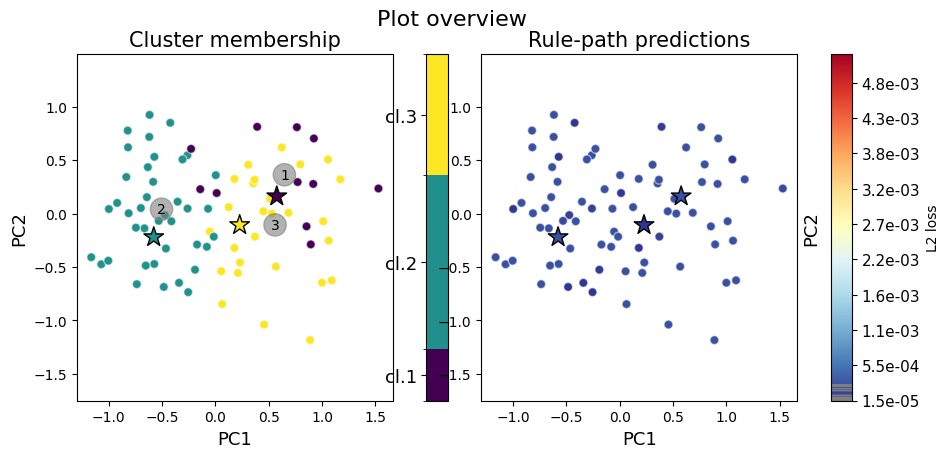

Bellatrex rules (text explanation):
########################  SAMPLE  ########################
source.remote_api_created | distanceFromCenter | longitude | latitude | daysUntilLastIssue
        1.000000          |      0.436916      | 0.698725  | 0.978069 |      0.195055     
##################   RULE WEIGHT: 0.15 ##################
Baseline prediction: 1.34e-02, 2.62e-02, 3.40e-03
node.   0:  source.remote_api_created >  0.750000  --> 1.35e-03, 8.98e-04, 0.00e+00
node. 170:    distanceFromCenter >  0.013865  --> 1.35e-03, 7.05e-04, 0.00e+00
node. 172:      longitude <= 0.703090  --> 1.36e-03, 5.11e-04, 0.00e+00
node. 173:        longitude <= 0.701548  --> 8.22e-04, 5.92e-04, 0.00e+00
node. 174:          latitude >  0.949991  --> 9.29e-04, 1.57e-04, 0.00e+00
node. 214:            latitude <= 0.986052  --> 7.38e-04, 1.83e-04, 0.00e+00
node. 215:              latitude <= 0.984573  --> 7.81e-04, 0.00e+00, 0.00e+00
node. 216:                daysUntilLastIssue >  0.072802  --> 5.26e-04, 0.0

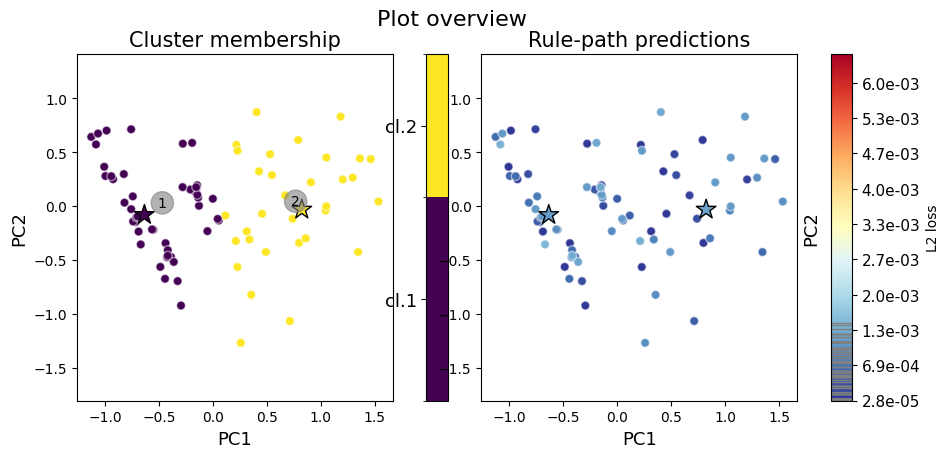

Bellatrex rules (text explanation):
########################  SAMPLE  ########################
source.remote_api_created | distanceFromCenter | longitude | daysUntilLastIssue
        1.000000          |      0.579011      | 0.702865  |      0.162088     
##################   RULE WEIGHT: 0.59 ##################
Baseline prediction: 1.34e-02, 2.62e-02, 3.40e-03
node.   0:  source.remote_api_created >  0.750000  --> 1.35e-03, 8.98e-04, 0.00e+00
node. 170:    distanceFromCenter >  0.013865  --> 1.35e-03, 7.05e-04, 0.00e+00
node. 172:      longitude <= 0.703090  --> 1.36e-03, 5.11e-04, 0.00e+00
node. 173:        longitude >  0.701548  --> 4.73e-03, 0.00e+00, 0.00e+00
node. 321:          longitude >  0.701574  --> 2.75e-03, 0.00e+00, 0.00e+00
node. 323:            daysUntilLastIssue <= 0.188187  --> 8.41e-04, 0.00e+00, 0.00e+00
node. 324:              daysUntilLastIssue >  0.129121  --> 1.60e-03, 0.00e+00, 0.00e+00
node. 332:                distanceFromCenter >  0.530902  --> 1.85e-03, 0.00

In [40]:
from bellatrex import BellatrexExplain, predict_helper
import matplotlib.pyplot as plt

# Fit the Bellatrex explainer on training data.
# p_grid controls how many explanation rules to extract (n_clusters) and other internal
# hyperparameters. Bellatrex auto-selects the best combination via fidelity to the RF.
Btrex_fitted = BellatrexExplain(
    clf_packed,
    set_up="auto",
    p_grid={"n_clusters": [1, 2, 3]},
    verbose=1,
).fit(X_train, y_train)

# Pre-compute training predictions once, used as background distribution in plot_visuals
y_train_pred = predict_helper(clf, X_train)

N_TEST_SAMPLES = 2
for i in range(N_TEST_SAMPLES):
    print(f"\n--- Explaining sample i={i} ---")

    tuned_method = Btrex_fitted.explain(X_test, i)

    # Plot 1: cluster overview (shows pre-selected trees and selected rules)
    fig1, axs1 = tuned_method.plot_overview(plot_gui=False)
    plt.show(fig1)

    # Plot 2: rule-level detail (single-output tasks only)
    if SETUP.lower() in ["binary", "regression", "survival"]:
        fig2, axs2 = tuned_method.plot_visuals(
            plot_max_depth=5,
            preds_distr=y_train_pred,
            conf_level=0.9,
            tot_digits=4,
            show=False,
        )
        plt.show(fig2)

    # Text explanation: save to file for later use:
    tuned_method.create_rules_txt()
    # Print the text explanation to console:
    tuned_method.print_rules_txt()